In [ ]:
include("./src/MPO_common.jl")
using .MPO_common
using JLD2
using ITensors
using LinearAlgebra
include("./src/iDMRG.jl")
using .iDMRG

# krylovdimmax=2, niter=1 are important inside the loop. In general if they are large, the computation time for each dmrg sweep is longer, and when it finally converges, we don't need it to be large. But for certain gapped phases, we can take them to be large to speed up the convergence and hence reduce the total number of sweeps.

# The algorithm used for noise is the DMRG_SSS modified to the 2-site case.

The output of our idmrg code is similar to Binder, Barthel (PHYSICAL REVIEW B98,235114(2018)). We have periodic cell $[A, \Lambda, B,... B , \Lambda^{-1}]$. We can then use the gauging methods described in Ref.

In [2]:
Ly = 3 # Here it denotes number of true unit-cells
uc = 2 * Ly
Jx = -0.5
Jy = -0.5
Jz = -2.0

-2.0

# Parameters for convergence:
Jx=-0.5
Jy=-0.5
Jz=-2.0
Ly=4
maxdimlist = [50, 100, 150]
sweeplist = [10, 10, 40];
updatedlist = idmrg_general(iH, psis0, lp10, rpuc, l2, l4; maxdim=maxdimlist[1], cutoff=1e-2, nsweeps=1)

for l = 1:3
    println("This is global sweep $l")
    if l <= 3
        for j = 1:2
            dmrgsweeptime = @elapsed updatedlist = idmrg_general(iH, updatedlist[1], updatedlist[2], updatedlist[3], updatedlist[4], updatedlist[5]; nsweeps=1, krylovdimmax=6, niter=3, maxdim=maxdimlist[l], cutoff=1e-10, noise=1e-3)
        end
    end
    for i = 1:sweeplist[l] #We turn on the noise in the first few runs
        println("Sweep $i")
        flush(stdout)
        dmrgsweeptime = @elapsed updatedlist = idmrg_general(iH, updatedlist[1], updatedlist[2], updatedlist[3], updatedlist[4], updatedlist[5]; nsweeps=1, krylovdimmax=6, niter=3, maxdim=maxdimlist[l], cutoff=1e-10)
        flush(stdout)
    end
end

In [51]:
oplist = MPOsum()
for i = 1:Ly
    mpoadd!(oplist, 4 * Jx, (2 * i - 1, "Sx"), (2 * i, "Sx"))
    mpoadd!(oplist, 4 * Jy, (2 * i - 1, "Sy"), (2 * i + 2 * Ly, "Sy"))
end

for i = 1:Ly
    mpoadd!(oplist, 4 * Jz, (2 * i, "Sz"), (mod1(2 * i + 1, 2 * Ly), "Sz"))
end

sites = siteinds("S=1/2", uc)
iH = op_to_hm_inf(oplist, sites);

leftinds = Vector{Index}(undef, uc)
for i = 1:uc
    leftinds[i] = commonind(iH[mod1(i - 1, uc)], iH[i])
end

resultvalue = iDMRG_init(sites, leftinds)
psis0 = resultvalue[1]
LP10 = resultvalue[2]
RPuc = resultvalue[3]
L_2 = resultvalue[4]
L_4 = resultvalue[5]
println("finish initialization")
flush(stdout)
#End of initialization

psis0, lp10, rpuc, l2, l4 = iDMRG_init(sites, leftinds)
maxdimlist = [50, 100, 150, 250, 200, 200]
sweeplist = [20, 20, 40, 10, 10, 20];
updatedlist = idmrg_general(iH, psis0, lp10, rpuc, l2, l4; maxdim=maxdimlist[1], cutoff=1e-2, nsweeps=1)

for l = 1:3
    println("This is global sweep $l")
    if l <= 3
        for j = 1:2
            dmrgsweeptime = @elapsed updatedlist = idmrg_general(iH, updatedlist[1], updatedlist[2], updatedlist[3], updatedlist[4], updatedlist[5]; nsweeps=1, krylovdimmax=6, niter=3, maxdim=maxdimlist[l], cutoff=1e-10, noise=1e-3)
        end
    end
    for i = 1:sweeplist[l] #We turn on the noise in the first few runs
        println("Sweep $i")
        flush(stdout)
        dmrgsweeptime = @elapsed updatedlist = idmrg_general(iH, updatedlist[1], updatedlist[2], updatedlist[3], updatedlist[4], updatedlist[5]; nsweeps=1, krylovdimmax=6, niter=3, maxdim=maxdimlist[l], cutoff=1e-10)
        flush(stdout)
    end
end


finish initialization
Maximum bond dimension is: 1
Energy is: -1.1332361086176748
Lambda overlap is: 1.0000000000000002
This is global sweep 1
Maximum bond dimension is: 4
Energy is: -1.3466122530371873
Lambda overlap is: 0.7058138149712857
Maximum bond dimension is: 6
Energy is: -1.0227554313185578
Lambda overlap is: 0.9999984150507899
Sweep 1
Maximum bond dimension is: 6
Energy is: -1.0227555568009166
Lambda overlap is: 0.9999999855980087
Sweep 2
Maximum bond dimension is: 10
Energy is: -1.0227633399953493
Lambda overlap is: 0.9999999511578255
Sweep 3
Maximum bond dimension is: 16
Energy is: -1.0279566123864103
Lambda overlap is: 0.9999117404084438
Sweep 4
Maximum bond dimension is: 23
Energy is: -1.0280428554565024
Lambda overlap is: 0.9987499334991259
Sweep 5
Maximum bond dimension is: 43
Energy is: -1.0332870999997372
Lambda overlap is: 0.9996532588580971
Sweep 6
Maximum bond dimension is: 49
Energy is: -1.0332107630369787
Lambda overlap is: 0.9996643004428415
Sweep 7
Maximum bond

In [46]:
function dispersion(a1,a2) 
 return sqrt((Jx*cos(2pi* a1) + Jy*cos(2pi* a2) + Jz)^2 + (Jx*sin(2pi* a1) + 
      Jy*sin(2pi* a2))^2)
end


dispersion (generic function with 1 method)

In [43]:
function integrand(alpha2, Ly, alphas)
    # average over alpha1, then divide by 2
    return (sum(a1 -> dispersion(a1, alpha2), alphas) / Ly) / 2
end

function mathematica_expr(Ly)
    alphas = range(1/Ly, stop=1.0, length=Ly)  # 1/Ly, 2/Ly, ..., 1
    f(a2) = integrand(a2, Ly, alphas)
    val, err = quadgk(f, 0.0, 1.0)             # corresponds to NIntegrate[..., {alpha2,0,1}]
    return val, err
end

mathematica_expr (generic function with 1 method)

In [48]:
using QuadGK
mathematica_expr(Ly)


(1.0333819832164692, 1.2205964239342393e-8)

# 1d TFIM

In [2]:
uc = 4

jz = -1.0
hx = -2.0

oplist = MPOsum()
for i = 1:uc
    mpoadd!(oplist, 4 * jz, (i, "Sz"), (i + 1, "Sz"))
    mpoadd!(oplist, 2 * hx, (i, "Sx"))
end

sites = siteinds("S=1/2", uc)
iH = op_to_hm_inf(oplist, sites);

In [3]:
finalstate = idmrg_run(iH, sites; maxdimlist=[50, 100, 250], sweeplist=[2, 2, 3], init_cutoff=1e-2, cutoff=1e-10)

finish initialization
Maximum bond dimension is: 2
Energy is: -2.190473536556369
<Λ(n)|Λ(n+1)> overlap is: 0.9911581811989701
== Global sweep 1 ==
Maximum bond dimension is: 5
Energy is: -2.127107545943373
<Λ(n)|Λ(n+1)> overlap is: 0.9999950382253208
  Sweep 1
Maximum bond dimension is: 5
Energy is: -2.127088819600594
<Λ(n)|Λ(n+1)> overlap is: 0.9999999999617517
  Sweep 2
Maximum bond dimension is: 5
Energy is: -2.127088819582493
<Λ(n)|Λ(n+1)> overlap is: 0.9999999999703374
== Global sweep 2 ==
Maximum bond dimension is: 5
Energy is: -2.1270888195844933
<Λ(n)|Λ(n+1)> overlap is: 0.9999999999690299
  Sweep 1
Maximum bond dimension is: 5
Energy is: -2.1270888195804005
<Λ(n)|Λ(n+1)> overlap is: 0.999999999969027
  Sweep 2
Maximum bond dimension is: 5
Energy is: -2.127088819582344
<Λ(n)|Λ(n+1)> overlap is: 0.9999999999703748
== Global sweep 3 ==
Maximum bond dimension is: 5
Energy is: -2.127088819584415
<Λ(n)|Λ(n+1)> overlap is: 0.999999999969029
  Sweep 1
Maximum bond dimension is: 5
Ener

MPSdata(MPS
[1] ((dim=2|id=662|"S=1/2,Site,n=1"), (dim=5|id=294|"Link,u"), (dim=5|id=135|"Link,u"))
[2] ((dim=2|id=328|"S=1/2,Site,n=2"), (dim=20|id=271|"Link,v"), (dim=5|id=231|"Link,v"))
[3] ((dim=10|id=431|"Link,v"), (dim=2|id=531|"S=1/2,Site,n=3"), (dim=20|id=271|"Link,v"))
[4] ((dim=5|id=531|"Link,v"), (dim=2|id=479|"S=1/2,Site,n=4"), (dim=10|id=431|"Link,v"))
, ITensor ord=3
Dim 1: (dim=5|id=294|"Link,u")
Dim 2: (dim=3|id=958)
Dim 3: (dim=5|id=294|"Link,u")'
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 5×3×5
[:, :, 1] =
      -93.46018392338304 + 0.0im  …       1.0000000000000095 + 0.0im
 -3.9951185216781985e-14 + 0.0im      1.2409087075121646e-16 + 0.0im
  2.8617071197392814e-14 + 0.0im      -4.890423417399574e-17 + 0.0im
    0.017477003030914363 + 0.0im     -1.4559271688503936e-16 + 0.0im
 -1.0722796956440392e-14 + 0.0im     -3.6309940095483954e-16 + 0.0im

[:, :, 2] =
  -3.097490049080732e-14 + 0.0im  …  1.1495261350267808e-16 + 0.0im
      -89.86455936893131 + 0.0im      

In [4]:
finalstate.ψ

MPS
[1] ((dim=2|id=662|"S=1/2,Site,n=1"), (dim=5|id=294|"Link,u"), (dim=5|id=135|"Link,u"))
[2] ((dim=2|id=328|"S=1/2,Site,n=2"), (dim=20|id=271|"Link,v"), (dim=5|id=231|"Link,v"))
[3] ((dim=10|id=431|"Link,v"), (dim=2|id=531|"S=1/2,Site,n=3"), (dim=20|id=271|"Link,v"))
[4] ((dim=5|id=531|"Link,v"), (dim=2|id=479|"S=1/2,Site,n=4"), (dim=10|id=431|"Link,v"))


In [73]:
# dispersion
ε(k, J, g) = 2J * sqrt(1 + g^2 - 2g*cos(k))

J = 1.0
g = 2.0

# e.g. integrate over the 1D Brillouin zone [0, π]
val = quadgk(k -> ε(k, J, g), 0, π; rtol=1e-10)[1]

# if you want the Brillouin-zone average:
avg = val / (2π)
println("BZ average = $avg")

BZ average = 2.12708881994673


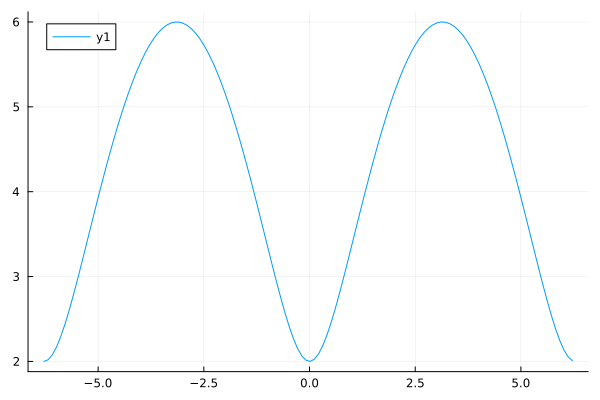

In [71]:
using Plots 
k=-2pi:0.1:2pi
plot(k,ε.(k, J, g))

In [74]:
2.12708881994673-2.1270888195824185

3.643116919249678e-10

In [ ]:
    newinitial = canonical_form_inversemethod(iH, iMPS, iLP, iRP, iL2, iL4; maxdim=1200, cutoff=1e-14, pseudoinv=1e-8)#Oh it seems that the cutoff here is crucial to obtain the correct Hamiltonian
    newa1, L = canonical_left(newinitial[1], isites)
    newb1, R = canonical_right(newinitial[2], isites)
    Acan = newa1
    Bcan = newb1
    Lambdacan = (L * newinitial[3]) * R
    Lambdacan = Lambdacan / sqrt(tr(array(Lambdacan) * transpose(conj(array(Lambdacan)))))


    
    Aeff = updatedHeffA(Acan, Lambdacan, isites, iH, 0)
    Beff = updatedHeffB(Bcan, Lambdacan, isites, iH, 0)
    heffA = Aeff[1]
    heffB = Beff[1]
    chi = dim(uniqueind(Acan[1], Acan[2], isites[1]))
    ITensors.space(::SiteType"Qeff") = chi

    returnvalue = Heff_segment_init(tna, tnb, uc, Acan, Bcan, Lambdacan, heffA, heffB, isites, iH, chi)
    sites_seg = returnvalue[1]
    H_seg = returnvalue[2]
    psi_seg = returnvalue[3]

We have $A=LML^{-1}$. Therefore $...MMMMM=...AAAAAL$, where one $L$ is pulled to left infinity. Similarly $B=R^{-1}MR$. Therefore $MMM...=RBBB...$.

In [9]:
newpsi,L1=left_canonical_form(finalstate,sites)

Converged after 2 sweeps with error 8.43769498715119e-15
Below is the result
0.999999999794398 + 0.0im


(MPS
[1] ((dim=2|id=662|"S=1/2,Site,n=1"), (dim=5|id=472|"Link,qr"), (dim=5|id=610|"Link,qr"))
[2] ((dim=5|id=472|"Link,qr"), (dim=2|id=328|"S=1/2,Site,n=2"), (dim=10|id=409|"Link,qr"))
[3] ((dim=10|id=409|"Link,qr"), (dim=2|id=531|"S=1/2,Site,n=3"), (dim=10|id=278|"Link,qr"))
[4] ((dim=10|id=278|"Link,qr"), (dim=2|id=479|"S=1/2,Site,n=4"), (dim=5|id=610|"Link,qr"))
, ITensor ord=2
Dim 1: (dim=5|id=610|"Link,qr")
Dim 2: (dim=5|id=294|"Link,u")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 5×5
 0.44765647251268786 + 0.0im  …  3.6946503148560517e-11 + 0.0im
                 0.0 - 0.0im     -0.0003996728222669804 - 0.0im
                 0.0 - 0.0im      0.0019599080622219045 + 0.0im
                 0.0 + 0.0im      3.699818229563334e-14 + 0.0im
                 0.0 + 0.0im         0.4453936038424269 + 0.0im)

In [107]:
newpsi[4]

ITensor ord=3 (dim=2|id=455|"S=1/2,Site,n=4") (dim=10|id=141|"Link,rq") (dim=5|id=91|"Link,rq")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [105]:
newpsi[2]

ITensor ord=3 (dim=20|id=608|"Link,rq") (dim=2|id=831|"S=1/2,Site,n=2") (dim=5|id=751|"Link,rq")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [7]:
liind=commonind(newpsi[1],newpsi[2])
b1=newpsi[1]
ri=(b1*delta(liind,prime(dag(liind))))*(prime(dag(b1))*delta(sites[1],prime(sites[1])))

ITensor ord=2 (dim=5|id=253|"Link,rq") (dim=5|id=253|"Link,rq")'
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [8]:
print(ri)

ITensor ord=2
Dim 1: (dim=5|id=253|"Link,rq")
Dim 2: (dim=5|id=253|"Link,rq")'
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 5×5
      1.0000000000000002 + 1.081755453189638e-27im   -8.411258848967869e-17 - 3.861316611631847e-25im  -1.0162817710720033e-17 + 2.3879054647023553e-25im   1.4260190880721058e-17 - 2.273628983412399e-26im    7.788396133666479e-18 + 2.883774147565837e-25im
  -8.411258848967869e-17 + 3.8834165360588906e-25im      0.9999999999999999 - 2.50407080353634e-27im     -5.80656060094653e-18 + 8.859727427215469e-26im    -2.416282033078657e-18 + 5.32704151791761e-26im    -3.743766843938521e-18 - 9.544998279355226e-27im
 -1.0162817710720033e-17 - 2.3475767887478607e-25im   -5.80656060094653e-18 - 9.092463963202046e-26im       0.9999999999999998 + 5.39349115470625e-29im     -8.400597432942111e-17 - 4.224266836598118e-26im  -2.9526459075107334e-17 + 8.166136332106616e-26im
  1.4260190880721058e-17 + 1.6489426883057017e-26im  -2.416282033078657e-18 - 5.304186075450198e-26i

In [5]:
newpsi,Rl=right_canonical_form(finalstate,sites)

Converged after 6 sweeps with error 4.853819488561578e-11
Below is the result
0.9999999999999907 - 4.2640513846216433e-16im


(MPS
[1] ((dim=5|id=95|"Link,rq"), (dim=2|id=662|"S=1/2,Site,n=1"), (dim=5|id=253|"Link,rq"))
[2] ((dim=20|id=581|"Link,rq"), (dim=2|id=328|"S=1/2,Site,n=2"), (dim=5|id=95|"Link,rq"))
[3] ((dim=10|id=571|"Link,rq"), (dim=2|id=531|"S=1/2,Site,n=3"), (dim=20|id=581|"Link,rq"))
[4] ((dim=2|id=479|"S=1/2,Site,n=4"), (dim=10|id=571|"Link,rq"), (dim=5|id=253|"Link,rq"))
, ITensor ord=2
Dim 1: (dim=5|id=253|"Link,rq")
Dim 2: (dim=5|id=294|"Link,u")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 5×5
     0.9911302715370144 + 0.0im                     …                   0.0 + 0.0im
 -1.1844052266729577e-9 + 1.0574815019018268e-11im                      0.0 + 0.0im
  -6.828144946105421e-9 + 1.708891720595015e-10im                       0.0 + 0.0im
   9.879473038505893e-7 + 3.1723930039996562e-19im                      0.0 + 0.0im
 -2.6222162244080366e-8 + 9.527290535270506e-10im      4.199799615359043e-5 + 0.0im)

In [103]:
println(Ll*Rl)

ITensor ord=2
Dim 1: (dim=5|id=992|"Link,qr")
Dim 2: (dim=5|id=91|"Link,rq")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 5×5
 0.443685881156788 + 0.0im  5.047989654749281e-9 + 4.192488986854632e-12im  2.9100908153783094e-8 + 6.775068570894917e-11im     4.426499868010839e-7 - 1.1992851173560287e-18im    1.1173549450328697e-7 + 3.777187608555217e-10im
               0.0 + 0.0im  0.059481028974318735 + 0.0im                     8.306016734753333e-8 + 8.051075261670069e-20im     3.861080539523523e-9 + 8.927204334229018e-12im     1.2326467563506499e-6 + 2.2306376528376013e-23im
               0.0 + 0.0im                   0.0 + 0.0im                    0.0010689382385333024 + 0.0im                    -1.6099436894019884e-11 - 1.4934526055241564e-14im    -8.713728267557883e-9 + 2.135976943460039e-24im
               0.0 + 0.0im                   0.0 + 0.0im                                      0.0 + 0.0im                      0.0001432847318067861 + 0.0im                     -2.48581812

In [97]:
newpsi,Ll=left_canonical_form(finalstate,sites)

Converged after 2 sweeps with error 8.43769498715119e-15
Below is the result
0.999999999794398 + 0.0im


(MPS
[1] ((dim=2|id=639|"S=1/2,Site,n=1"), (dim=5|id=657|"Link,qr"), (dim=5|id=992|"Link,qr"))
[2] ((dim=5|id=657|"Link,qr"), (dim=2|id=831|"S=1/2,Site,n=2"), (dim=10|id=176|"Link,qr"))
[3] ((dim=10|id=176|"Link,qr"), (dim=2|id=802|"S=1/2,Site,n=3"), (dim=10|id=205|"Link,qr"))
[4] ((dim=10|id=205|"Link,qr"), (dim=2|id=455|"S=1/2,Site,n=4"), (dim=5|id=992|"Link,qr"))
, ITensor ord=2
Dim 1: (dim=5|id=992|"Link,qr")
Dim 2: (dim=5|id=834|"Link,u")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 5×5
 0.44765647251268786 + 0.0im  …  3.6946503148560517e-11 + 0.0im
                 0.0 - 0.0im     -0.0003996728222669804 - 0.0im
                 0.0 - 0.0im      0.0019599080622219045 + 0.0im
                 0.0 + 0.0im      3.699818229563334e-14 + 0.0im
                 0.0 + 0.0im         0.4453936038424269 + 0.0im)